# Preparação dos Dados

In [1]:
from datetime import datetime
from time import time
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import h5py

# Módulo do software da implementação do MOD17
import mod17
from mod17 import MOD17, PFT_VALID
from mod17.utils import restore_bplut, pft_remap

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.core.callback import Callback
from IPython.display import display, HTML
from typing import List, Union

def Reco_Horario(serie_reco:pd.Series) -> float:   
    return serie_reco.between_time('20:00', '06:00').sum()

def Gpp_Horario(serie_gpp: pd.Series) -> float:   
    return serie_gpp.between_time('07:00', '19:00').sum()

def create_flux_data(dataframe: pd.DataFrame, var: List[Union[str, str]],kg_c = True) -> pd.DataFrame:
    """
    Cria um DataFrame com os dados de fluxo de carbono de acordo com a variável alvo especificada.
    
    Args:
        data_df (pd.DataFrame): DataFrame que conterá os dados de fluxo de carbono.
        dataframe (pd.DataFrame): DataFrame contendo os dados originais.
        var (List[str, str]): Lista contendo o nome da variável alvo e sua respectiva coluna nos dados originais.
        
    Returns:
        pd.DataFrame: DataFrame contendo os dados de fluxo de carbono atualizados.
    """
    # Mapeamento das funções para calcular as variáveis alvo
    var_names = {
        'gpp': Gpp_Horario,
        'reco': Reco_Horario
        # Adicione aqui outras variáveis alvo, se necessário
    }
    
    data_df = pd.DataFrame(index=np.unique(dataframe.index.date)) # index = datas do dataframe (DADOS NÃO SÃO PUXADOS)
    
    data_df[f'{var[0]}'] = pd.Series(dtype='float') # Cria uma coluna com o nome da variável alvo
    
    for date in data_df.index:
        """
        Loop através de cada data para calcular os valores desejados.
        """
        # Obtendo a data no formato YYYY/MM/DD
        
        date_str = date.strftime("%Y-%m-%d")
        
        # Obtendo o valor da variável alvo do dataframe original
        var_alvo = dataframe[var[1]].loc[date_str]
        
        # Chamando a função apropriada para calcular a variável alvo
        var_alvo = var_names.get(var[0].lower())(var_alvo)
        
        # Atualizando o DataFrame com o valor calculado
        data_df.loc[date, var[0]] = var_alvo
    
    # Aplicando transformação para kgC
    if kg_c:
        data_df[var[0]] = data_df[var[0]].apply(to_kgC)
    data_df.index = data_df.reset_index()['index'].apply(lambda x:pd.to_datetime(x))
    
    return data_df

def to_kgC(x):
    """Retorna valores convertidos para kg C m² s"""
    umol2mol = 1e-06
    Cmol = 0.012011
    #minutesinseconds = 1800
    days2seconds = 86400
    kg2g = 1000 # Precisamos em kg, não em g, por isso não multipliquei por 1000
    
    return x * umol2mol * Cmol * days2seconds # cálculo dado pelo professor

cax = pd.read_csv('./caxiuana/GEPCAX.txt', delimiter='\t')
cax['ano2'] = cax['ano2'].apply(lambda x:str(int(x)))
cax['dia2'] = cax['dia2'].apply(lambda x:str(int(x)))
cax['datetime'] = cax['ano2'] + cax['dia2']
cax.index =  cax['datetime'].apply(lambda x:datetime.strptime(str(x), '%Y%j'))

observacoes_cax = cax['GEP']
observacoes_cax = observacoes_cax.rename_axis('index')
observacoes_cax = observacoes_cax.rename('GPP')

observacoes_cax = ExponentialSmoothing(observacoes_cax, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues


## Cálculo do GPP com os Parâmetros da BPLUT (MERRA-2)

### Caxiuana

In [2]:
def constructor_2(path):
    """Função para construir os Dataframes dos dados metereológicos do MERRA-2"""
    nome = path.split('/')[1].split('_')[0]
    df = pd.read_csv(path, parse_dates=['date'])
    df = df.rename({'albedo':nome},axis=1)
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df


# Leitura e pré-processamento dos dados de temperatura
tday = constructor_2('./caxiuana/cax_t10m.csv') - 273.15 #( K° -> C°)
tday = tday['2005':'2008']
tmin = tday['T10M'].resample('D').min().values  # Reamostrando para Temperatura mínima diária
tmean_caxiuana = tday['T10M'].resample('D').mean().values  # Temperatura média diária
tmean_vpd = tday['T10M'].between_time('9:00', '21:00').resample('D').mean().values
             
# Leitura e pré-processamento dos dados de razão de mistura de vapor de água
qv10m = constructor_2('./caxiuana/cax_qv10m.csv') # unidade: "Mass fraction" (kg/kg)
qv10m = qv10m['2005':'2008']
qv10m = pd.to_numeric(qv10m['QV10M']).between_time('9:00', '21:00').resample('D').mean().values

# Leitura e pré-processamento dos dados de pressão atmosférica
ps = constructor_2('./caxiuana/cax_ps.csv') # unidade: Pa  # Removendo vírgulas dos valores
ps = ps['2005':'2008']
ps['PS'] = pd.to_numeric(ps['PS'])
ps = ps.between_time('9:00', '21:00').resample('D').mean()
ps = pd.to_numeric(ps['PS']).values

# Leitura e pré-processamento dos dados de radiação solar incidente
SWGNT = constructor_2('./caxiuana/cax_swgnt.csv')
SWGNT = SWGNT['2005':'2008']
SWGNT = SWGNT['SWGNT'].resample('D').mean().values # unidade: W/m^2

# Função para converter datas no formato MODIS
def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

# Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
fpar = pd.read_csv('./caxiuana/cax_fpar.csv', header=None,na_values='F') # unidade: (%)
fpar.index = fpar[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
fpar = fpar.drop([0,1,2,3,4], axis=1)
fpar.columns = range(len(fpar.columns))
fpar = fpar[144]

# ================================

# Tratamento de dados faltando usando interpolação linear (8 dias -> diário)
fpar = fpar.resample('D').interpolate('linear')['2005-01-01':'2008-12-31']
fpar = fpar.values

drivers_caxiuana = [
    fpar[:][...,None],
    tmin[:][...,None],
    MOD17.vpd(qv10m, ps, tmean_vpd)[...,None],
    MOD17.par(SWGNT)[:][...,None]
]
drivers_caxiuana[2] = np.where(drivers_caxiuana[2] < 0, 0, drivers_caxiuana[2]) # VPD < 0 = 0

# Gerando GPP a partir dos dados do bioma "Evergreen Broadleaf Forest" como parâmetro diretamente
#parametros = pd.read_csv('mod17_bplut/MOD17_BPLUT_CX.X_MERRA_NASA.csv')['EBF=1'].values

parametros = [0.001405, -8.0, 9.09, 1000.0, 4000.0, 26.9, 2.0, 2.0, 1.1, 0.162, 0.00604, 0.00519, 0.00397] ## Igual ao acima

gpp_ebf = MOD17._gpp(parametros,drivers_caxiuana[0],drivers_caxiuana[1],drivers_caxiuana[2],drivers_caxiuana[3]) # Considerar como GPP do algorítmo

gpp_alg_caxiuana = pd.DataFrame(gpp_ebf,index=observacoes_cax.index)

gpp_alg_caxiuana = ExponentialSmoothing(gpp_alg_caxiuana, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

## Dados de GPP do MOD17

### Caxiuana

In [3]:
# Função para converter datas no formato MODIS
def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

# Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
Gpp_mod = pd.read_csv('./GPP_MODIS/Gpp_500m (1).csv', header=None,na_values='F') # unidade: (%)
Gpp_mod.index = Gpp_mod[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
Gpp_mod = Gpp_mod.drop([0,1,2,3,4], axis=1)
Gpp_mod.columns = range(len(Gpp_mod.columns))
Gpp_mod = Gpp_mod[144].to_frame().rename(columns={144:'Gpp_modis'})
caxiuana_gpp_mod = Gpp_mod['2005-01-01':'2008-12-27'] * 0.0001 * 1000
caxiuana_gpp_mod = caxiuana_gpp_mod['Gpp_modis']

## Agregando os dados Para a Resolução Temporal do MOD17

In [4]:
observacoes_caxiuana = observacoes_cax

index_caxiuana = observacoes_caxiuana.index

#Organizando os dados das observacões das torres para amostras de 8 dias
#Mesma resolução temporal do MOD17
gpp_gc_8d_2005_teste = observacoes_caxiuana['2005':'2005'].resample('8D').sum()
gpp_gc_8d_2006_teste = observacoes_caxiuana['2006':'2006'].resample('8D').sum()
gpp_gc_8d_2007_teste = observacoes_caxiuana['2007':'2007'].resample('8D').sum()
gpp_gc_8d_2008_teste = observacoes_caxiuana['2008':'2008'].resample('8D').sum()
observacoes_caxiuana = pd.concat([gpp_gc_8d_2005_teste,gpp_gc_8d_2006_teste,gpp_gc_8d_2007_teste,gpp_gc_8d_2008_teste],axis=0)


#Calculando RMSE entre os dados do satélite e torre
rmse_mod_caxiuana = np.sqrt(mean_squared_error(y_true=observacoes_caxiuana, y_pred=caxiuana_gpp_mod))


#Organizando os dados de GPP calculado com o algoritmo do mod17 amostras de 8 dias
#Mesma resolução temporal do MOD17
gpp_ebf_8d_2005_caxiuana = gpp_alg_caxiuana['2005':'2005'].resample('8D').sum()
gpp_ebf_8d_2006_caxiuana = gpp_alg_caxiuana['2006':'2006'].resample('8D').sum()
gpp_ebf_8d_2007_caxiuana = gpp_alg_caxiuana['2007':'2007'].resample('8D').sum()
gpp_ebf_8d_2008_caxiuana = gpp_alg_caxiuana['2008':'2008'].resample('8D').sum()
gpp_algpad_caxiuana = pd.concat([gpp_ebf_8d_2005_caxiuana,gpp_ebf_8d_2006_caxiuana,gpp_ebf_8d_2007_caxiuana,gpp_ebf_8d_2008_caxiuana],axis=0)



#Calculando o RMSE o algorotimo do mod17 e dados da torre.
rmse_algpad_caxiuana = np.sqrt(mean_squared_error(y_true=observacoes_caxiuana, y_pred=gpp_algpad_caxiuana))

initial_population = np.array([0.001405, -8.0, 9.09, 1000.0, 4000.0, 26.9, 2.0, 2.0, 1.1, 0.162, 0.00604, 0.00519, 0.00397])

# Algoritmo Genético


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  |     LUEmax    |    Tmin_min   |    Tmin_max   |    VPD_min    |    VPD_max    | RMSE caxiuana
     1 |     1000 |  0.0027012736 | -3.863086E+00 |  8.4943744797 |  4.104852E+02 |  3.381866E+03 |  3.531807E+01
     2 |     2000 |  0.0024361947 | -1.076132E+01 |  2.760406E+01 |  9.340453E+01 |  6.097070E+03 |  3.062583E+01
     3 |     3000 |  0.0024361947 | -1.076132E+01 |  2.760406E+01 |  9.340453E+01 |  6.097070E+03 |  3.062583E+01
     4 |     4000 |  0.0026147055 | -1.121327E+01 |  2.797944E+01 |  1.192122E+02 |  5.026918E+03 |  3.060712E+01
     5 |     5000 |  0.0025480960 | -1.731973E+01 |  2.848102E+01 |  8.168915E+01 |  5.466873E+03 |  3.058241E+01
Function 'exec_model' executed in 92.3942s


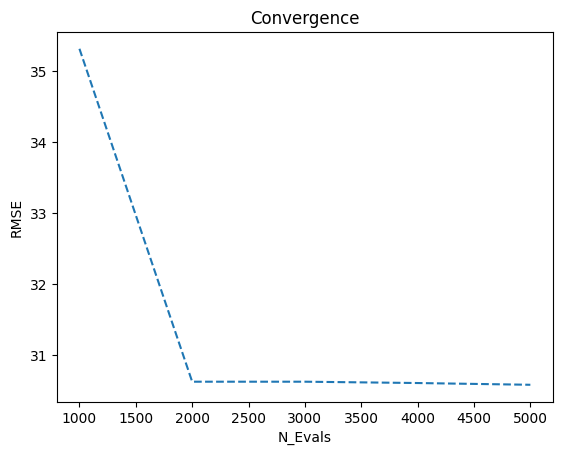

Porcentagem de melhora: 3.1508185291555533


In [5]:
def get_data(x):
    '''Função para calcular os dados de GPP com os parametros em otimização pelo Algoritmo Genético'''
    global observacoes_caxiuana
   
    previsoes_caxiuana = MOD17._gpp(x, drivers_caxiuana[0], drivers_caxiuana[1], drivers_caxiuana[2], drivers_caxiuana[3])
    previsoes_caxiuana = pd.DataFrame(previsoes_caxiuana,index=index_caxiuana)
    previsoes_caxiuana = ExponentialSmoothing(previsoes_caxiuana, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

    
    gpp_gc_8d_2005_teste = previsoes_caxiuana['2005':'2005'].resample('8D').sum()
    gpp_gc_8d_2006_teste = previsoes_caxiuana['2006':'2006'].resample('8D').sum()
    gpp_gc_8d_2007_teste = previsoes_caxiuana['2007':'2007'].resample('8D').sum()
    gpp_gc_8d_2008_teste = previsoes_caxiuana['2008':'2008'].resample('8D').sum()
    previsoes_caxiuana = pd.concat([gpp_gc_8d_2005_teste,gpp_gc_8d_2006_teste,gpp_gc_8d_2007_teste,gpp_gc_8d_2008_teste],axis=0) # previsões caxiuana

    
    return previsoes_caxiuana

class MyOutput(Output):
    '''Classe utilizada para printar os dados da otimização em andamento pelo AG'''
    def __init__(self):
        super().__init__()
        self.LUEmax = Column("LUEmax", width=13)
        self.Tmin_min = Column("Tmin_min", width=13)
        self.Tmin_max = Column("Tmin_max", width=13)
        self.VPD_min = Column("VPD_min", width=13)
        self.VPD_max = Column("VPD_max", width=13)
        self.RMSE_caxiuana = Column("RMSE caxiuana", width=13)
        self.columns += [self.LUEmax, self.Tmin_min,self.Tmin_max,self.VPD_min,self.VPD_max,self.RMSE_caxiuana]


    def update(self, algorithm):

        global observacoes_caxiuana
        
        super().update(algorithm)
        self.LUEmax.set(algorithm.pop.get("X")[0][0])
        self.Tmin_min.set(algorithm.pop.get("X")[0][1])
        self.Tmin_max.set(algorithm.pop.get("X")[0][2])
        self.VPD_min.set(algorithm.pop.get("X")[0][3])
        self.VPD_max.set(algorithm.pop.get("X")[0][4])

        previsoes_caxiuana= get_data(algorithm.pop.get("X")[0])

        rmse_caxiuana = np.round(np.sqrt(mean_squared_error(y_true=observacoes_caxiuana, y_pred=previsoes_caxiuana)),5)
        
        self.RMSE_caxiuana.set(rmse_caxiuana)
        


class MyCustomProblem(ElementwiseProblem,):
    '''Classe que implementa o problema a ser otimizado'''
    def __init__(self):
        super().__init__(
            n_var=5, #número de variaveis a serem otimizadas
            n_obj=1, #número de objetivos do GA
            n_constr=1,
            xl=np.array([0.3 / 1000, -35, 6, 60, 1500]),  #valores mínimos 
            xu=np.array([3.0 / 1000, -2, 30, 1000, 6500]),#valores máximos
        )


    def _evaluate(self, x, out, *args, **kwargs):
        '''Função utilizada para cálculo da fitness de cada individuo da população do AG'''
        global observacoes_caxiuana
       
        previsoes_caxiuana = get_data(x)

        rmse_caxiuana = np.sqrt(mean_squared_error(y_true=observacoes_caxiuana, y_pred=previsoes_caxiuana))

        # Armazenar na saída
        out["F"] = rmse_caxiuana


class MyCallback(Callback):
    '''Classe utilizada para salvar dados do GA sem precisar usar o parâmetro save_history que ocupa muita memória e deixa o AG mais lento'''   
    def __init__(self) -> None:
        super().__init__()
        self.n_evals = []
        self.opt = []

    def notify(self, algorithm):
        self.n_evals.append(algorithm.evaluator.n_eval)
        self.opt.append(algorithm.opt[0].F)       


# Defina o problema
problem = MyCustomProblem()
callback = MyCallback()
sampling = FloatRandomSampling()

pop_size = 1000

# Defina o algoritmo GA
algorithm = GA(
    pop_size=pop_size,
    eliminate_duplicates=True,
    sampling=sampling(problem, pop_size).get("X"),
    mutation=PolynomialMutation(prob=0.5, eta=20),
    crossover=SBX(prob=0.8, eta=20)
)


def timer_func(func):
    # This function shows the execution time of
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func


@timer_func
def exec_model():
    # Execute a otimização
    res = minimize(problem,
                   algorithm,
                   ('n_gen', 5),
                   seed=2,
                   output=MyOutput(),
                   callback=callback,
                   save_history=False,
                   verbose=True)
    return res

res = exec_model()

#Plotando o gráfico de convergência
plt.title("Convergence")
plt.plot(callback.n_evals, callback.opt, "--")
plt.ylabel("RMSE")
plt.xlabel("N_Evals")

plt.show()
#plt.savefig("convergence.png", dpi=300)

rmse_GA = res.algorithm.callback.opt[-1][0]
melhor_params = res.algorithm.opt[0].X
print(f'Porcentagem de melhora: {-((rmse_GA - rmse_mod_caxiuana) / rmse_mod_caxiuana) * 100}')

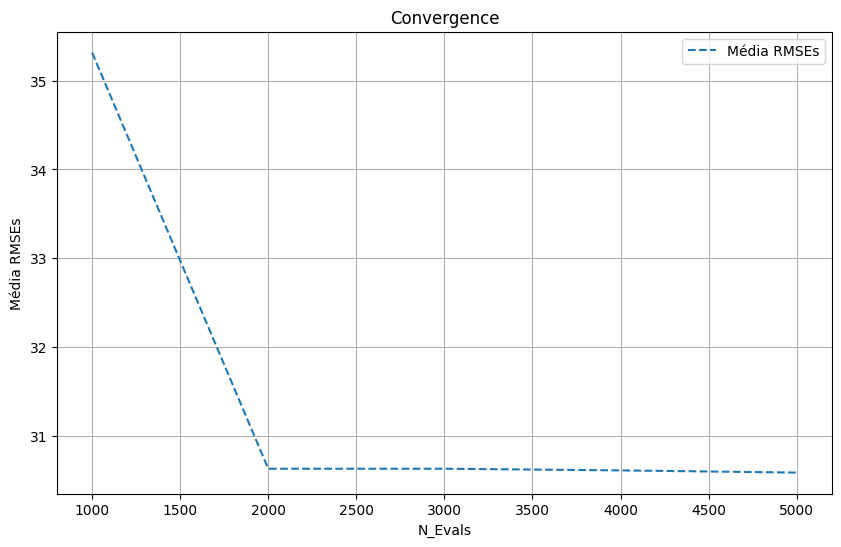

In [6]:
# Plotando o gráfico de convergência em relação ao número de gerações
plt.figure(figsize=(10, 6))
plt.title("Convergence")
plt.plot(callback.n_evals, callback.opt, "--", label="Média RMSEs")
plt.ylabel("Média RMSEs")
plt.xlabel("N_Evals")
plt.legend()
plt.grid(True)
#plt.savefig("convergence2.png", dpi=300)
plt.show()

# Resultados

## Análise do GPP

In [7]:
def get_data(x):
    global observacoes_caxiuana
    previsoes_caxiuana = MOD17._gpp(x, drivers_caxiuana[0], drivers_caxiuana[1], drivers_caxiuana[2], drivers_caxiuana[3])
    previsoes_caxiuana = pd.DataFrame(previsoes_caxiuana,index=index_caxiuana)
    previsoes_caxiuana = ExponentialSmoothing(previsoes_caxiuana, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

    
    gpp_gc_8d_2005_teste = previsoes_caxiuana['2005':'2005'].resample('8D').sum()
    gpp_gc_8d_2006_teste = previsoes_caxiuana['2006':'2006'].resample('8D').sum()
    gpp_gc_8d_2007_teste = previsoes_caxiuana['2007':'2007'].resample('8D').sum()
    gpp_gc_8d_2008_teste = previsoes_caxiuana['2008':'2008'].resample('8D').sum()
    previsoes_caxiuana = pd.concat([gpp_gc_8d_2005_teste,gpp_gc_8d_2006_teste,gpp_gc_8d_2007_teste,gpp_gc_8d_2008_teste],axis=0) # previsões caxiuana

   
    return previsoes_caxiuana

parametros_padrao = initial_population
previsoes_caxiuana_GA = get_data(melhor_params)
rmse_st = np.sqrt(mean_squared_error(y_true=observacoes_caxiuana,y_pred=previsoes_caxiuana_GA))

print(f'Porcentagem de melhora: {-((rmse_st - rmse_mod_caxiuana) / rmse_mod_caxiuana) * 100}')

Porcentagem de melhora: 3.1508185291555533


### Erro Absoluto Diário

In [8]:
gpp_alg_caxiuana = np.nanmean(MOD17._gpp(melhor_params,drivers_caxiuana[0], drivers_caxiuana[1], drivers_caxiuana[2], drivers_caxiuana[3]), axis = -1)
gpp_alg_caxiuana = pd.DataFrame(gpp_alg_caxiuana,index=index_caxiuana)
smoothed_gpp_alg_caxiuana = ExponentialSmoothing(gpp_alg_caxiuana, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

gpp_gc_8d_2005_teste = smoothed_gpp_alg_caxiuana['2005':'2005'].resample('8D').sum()
gpp_gc_8d_2006_teste = smoothed_gpp_alg_caxiuana['2006':'2006'].resample('8D').sum()
gpp_gc_8d_2007_teste = smoothed_gpp_alg_caxiuana['2007':'2007'].resample('8D').sum()
gpp_gc_8d_2008_teste = smoothed_gpp_alg_caxiuana['2008':'2008'].resample('8D').sum()
new_params_caxiuana = pd.concat([gpp_gc_8d_2005_teste,gpp_gc_8d_2006_teste,gpp_gc_8d_2007_teste,gpp_gc_8d_2008_teste],axis=0)



erro_absoluto_modelo1 = abs(observacoes_caxiuana - new_params_caxiuana)
erro_absoluto_modelo2 = abs(observacoes_caxiuana - caxiuana_gpp_mod)
erro_absoluto_modelo3_caxiuana = abs(observacoes_caxiuana - smoothed_gpp_alg_caxiuana)

# Calcula o erro absoluto diário para cada modelo
eda_modelo1 = erro_absoluto_modelo1
eda_modelo2 = erro_absoluto_modelo2
eda_modelo3_caxiuana = erro_absoluto_modelo3_caxiuana


# Cria um DataFrame para armazenar os erros absolutos diários de ambos os modelos
erro_absoluto_caxiuana = pd.DataFrame({
    'Erro Diário $GPP_{MERRA-2}$ (Novo)': eda_modelo1,
    'Erro Diário $GPP_{MOD17}$': eda_modelo2,
    'Erro Diário $GPP_{MERRA-2}$': eda_modelo3_caxiuana
})



# Calcula o RMSE diário para cada modelo
eda_modelo1 = erro_absoluto_modelo1
eda_modelo2 = erro_absoluto_modelo2




display(erro_absoluto_caxiuana.describe())


,Erro Diário $GPP_{MERRA-2}$ (Novo),Erro Diário $GPP_{MOD17}$,Erro Diário $GPP_{MERRA-2}$
count,184.000000,184.000000,184.000000
mean,25.336793,26.696635,75.095773
std,17.173626,16.910738,17.575194
min,0.012879,0.024061,20.220292
25%,11.338125,12.345092,63.190521
50%,22.591497,26.070517,75.222250
75%,37.805373,39.948292,89.003213
max,78.099458,66.610162,113.326838


### Boxplot Mensal das Fontes de GPP

C:\Users\alanb\AppData\Local\Temp\ipykernel_13892\1314930444.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  observacoes_caxiuana_monthly = observacoes_caxiuana.resample('M').mean()
C:\Users\alanb\AppData\Local\Temp\ipykernel_13892\1314930444.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  new_params_caxiuana_monthly = new_params_caxiuana.resample('M').mean()
C:\Users\alanb\AppData\Local\Temp\ipykernel_13892\1314930444.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  caxiuana_gpp_mod_monthly = caxiuana_gpp_mod.resample('M').mean()
C:\Users\alanb\AppData\Local\Temp\ipykernel_13892\1314930444.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  smoothed_gpp_algpad_caxiuana_monthly = gpp_algpad_caxiuana.resample('M').mean()


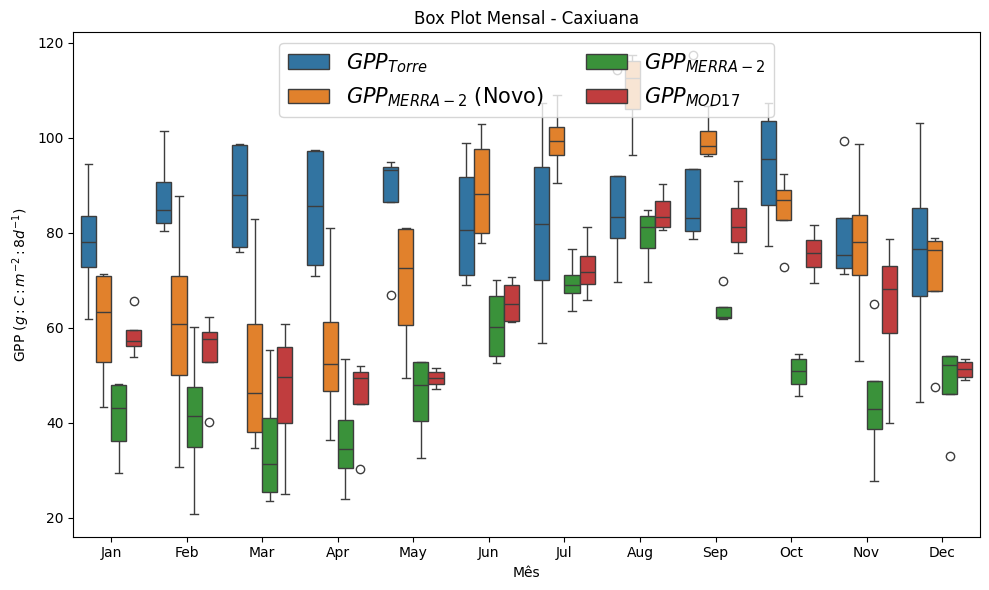

In [9]:
# Definindo os dados mensais de Caxiuana
observacoes_caxiuana_monthly = observacoes_caxiuana.resample('M').mean()
new_params_caxiuana_monthly = new_params_caxiuana.resample('M').mean()
caxiuana_gpp_mod_monthly = caxiuana_gpp_mod.resample('M').mean()
smoothed_gpp_algpad_caxiuana_monthly = gpp_algpad_caxiuana.resample('M').mean()

# Criando DataFrame para Caxiuana com os dados resampleados
df_caxiuana = pd.DataFrame({
    '$GPP_{Torre}$': observacoes_caxiuana_monthly,
    '$GPP_{MERRA-2}$ (Novo)': new_params_caxiuana_monthly,
    '$GPP_{MERRA-2}$': smoothed_gpp_algpad_caxiuana_monthly,
    '$GPP_{MOD17}$': caxiuana_gpp_mod_monthly,
})

# Resetando o índice para ter uma coluna de datas
df_caxiuana.reset_index(inplace=True)

# Derretendo o DataFrame para ter todas as variáveis em uma única coluna
df_caxiuana_melted = df_caxiuana.melt(id_vars='index', var_name='Medição de GPP', value_name='Valor')

# Obtendo o ano e o mês de cada data
df_caxiuana_melted['Ano'] = df_caxiuana_melted['index'].dt.year
df_caxiuana_melted['Mes'] = df_caxiuana_melted['index'].dt.strftime('%b')

# Plotando os boxplots em subplots
fig, axes = plt.subplots(figsize=(10, 6))  # Criando subplots com 2 linhas e 1 coluna

# Boxplot para Caxiuana
sns.boxplot(data=df_caxiuana_melted, x='Mes', y='Valor', hue='Medição de GPP', dodge=True, ax=axes)
axes.set_title('Box Plot Mensal - Caxiuana')  # Definindo título
axes.set_ylabel('GPP ($g : C : m^{-2} : 8d^{-1}$)')  # Definindo rótulo do eixo y
axes.set_xlabel('Mês')  # Definindo rótulo do eixo x
axes.legend(loc='upper center', fontsize=15, ncol=2)  # Definindo legenda



plt.tight_layout()  # Ajustando layout
#plt.savefig('BoxPlot_caxiuana_Peru.png', dpi=300, bbox_inches='tight', pad_inches=0.2)  # Salvando figura
plt.show()

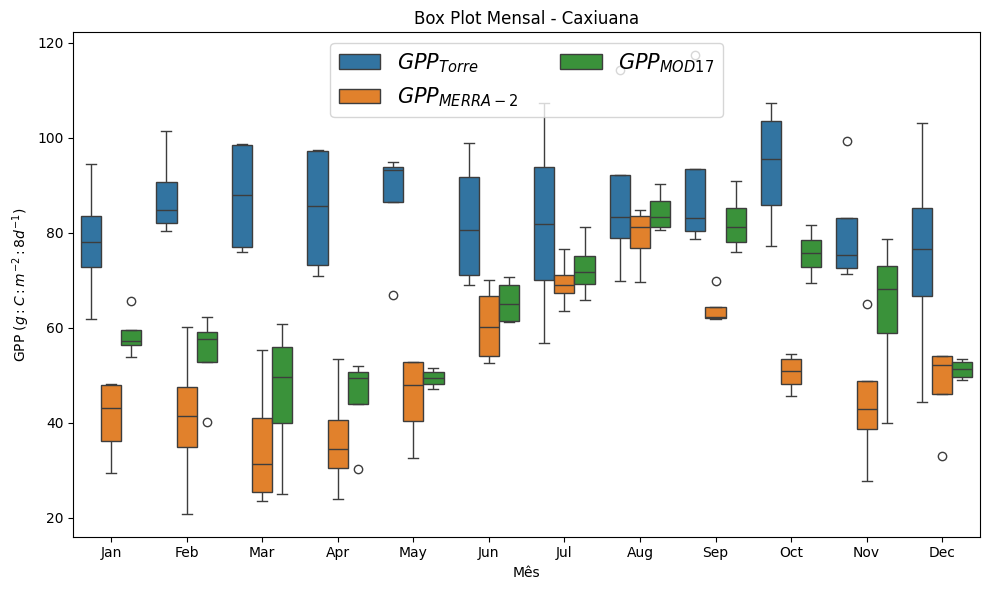

In [10]:
# Derretendo o DataFrame para ter todas as variáveis em uma única colun
df_caxiuana_melted = df_caxiuana.drop(['$GPP_{MERRA-2}$ (Novo)'],axis=1).melt(id_vars='index', var_name='Medição de GPP', value_name='Valor')

# Obtendo o ano e o mês de cada data
df_caxiuana_melted['Ano'] = df_caxiuana_melted['index'].dt.year
df_caxiuana_melted['Mes'] = df_caxiuana_melted['index'].dt.strftime('%b')

# Plotando os boxplots em subplots
fig, axes = plt.subplots(figsize=(10, 6))  # Criando subplots com 2 linhas e 1 coluna

# Boxplot para Santarém
sns.boxplot(data=df_caxiuana_melted, x='Mes', y='Valor', hue='Medição de GPP', dodge=True, ax=axes)
axes.set_title('Box Plot Mensal - Caxiuana')  # Definindo título
axes.set_ylabel('GPP ($g : C : m^{-2} : 8d^{-1}$)')  # Definindo rótulo do eixo y
axes.set_xlabel('Mês')  # Definindo rótulo do eixo x
axes.legend(loc='upper center', fontsize=15, ncol=2)  # Definindo legenda

plt.tight_layout()  # Ajustando layout
#plt.savefig('BoxPlot_caxiuana_Peru.png', dpi=300, bbox_inches='tight', pad_inches=0.2)  # Salvando figura
plt.show()

## Análise do NPP

### Cálculo do NPP

In [11]:
# Leitura e pré-processamento dos dados de NPP (kgC/m²/year)
npp_mod = pd.read_csv('./NPP_MODIS/Npp_500m.csv', header=None,na_values='F')
npp_mod.index = npp_mod[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
npp_mod = npp_mod.drop([0,1,2,3,4], axis=1)
npp_mod.columns = range(len(npp_mod.columns))
npp_modis = npp_mod[144]
npp_modis_st = npp_modis[['2005-01-01','2006-01-01','2007-01-01','2008-01-01']] * 0.0001

# Carregar os dados da AMERIFLUX

#AMERIFLUX GPP
ameriflux = pd.read_csv('./caxiuana/GEPCAX.txt', delimiter='\t')
# Adicionar a coluna 'data2' com o valor '00:00:00' na primeira linha
ameriflux.loc[:, 'data2'] = '00:00:00'
# Converter a coluna 'ano2' para string e a coluna 'dia2' para string de três dígitos
ameriflux['ano2'] = ameriflux['ano2'].astype(str)
ameriflux['dia2'] = ameriflux['dia2'].astype(float).astype(int).astype(str).str.zfill(3)
# Concatenar 'ano2' e 'dia2' com 'data2'
ameriflux.index = pd.to_datetime(ameriflux['ano2'] + ameriflux['dia2'] + ' ' + ameriflux['data2'], format='%Y%j %H:%M:%S')

# AMERIFLUX NEE
amerifluxnee = pd.read_csv('./caxiuana/neeCAX.txt', delimiter='\t')
# Adicionar a coluna 'data' com o valor '00:00:00'
amerifluxnee['data'] = '00:00:00'
# Converter a coluna 'ano' para string e a coluna 'dia' para string de três dígitos
amerifluxnee['ano'] = amerifluxnee['ano'].astype(float).astype(int).astype(str)
amerifluxnee['dia'] = amerifluxnee['dia'].astype(float).astype(int).astype(str).str.zfill(3)
# Concatenar 'ano' e 'dia' com 'data'
amerifluxnee.index = pd.to_datetime(amerifluxnee['ano'] + amerifluxnee['dia'] + ' ' + amerifluxnee['data'], format='%Y%j %H:%M:%S')

# AMERIFLUX RECO
amerifluxreco = pd.read_csv('./caxiuana/recoCAX.txt', delimiter='\t')
# Adicionar a coluna 'data' com o valor '00:00:00'
amerifluxreco['data'] = '00:00:00'
# Converter a coluna 'ano' para string e a coluna 'dia' para string de três dígitos
amerifluxreco['ano'] = amerifluxreco['ano'].astype(float).astype(int).astype(str)
amerifluxreco['dia'] = amerifluxreco['dia'].astype(float).astype(int).astype(str).str.zfill(3)
# Concatenar 'ano' e 'dia' com 'data'
amerifluxreco.index = pd.to_datetime(amerifluxreco['ano'] + amerifluxreco['dia'] + ' ' + amerifluxreco['data'], format='%Y%j %H:%M:%S')



nee = amerifluxnee['NEE'].copy()
reco = amerifluxreco['reco'].copy()
gpp = ameriflux['GEP'].copy()

nee_kgc = nee.apply(to_kgC)
reco_kgc_total = reco.apply(to_kgC)
npp_caxiuana = (-nee_kgc + (0.3919 * reco_kgc_total)).resample('YE').sum()

# Leitura e pré-processamento dos dados de LAI
lai_caxiuana = pd.read_csv('./caxiuana/Lai_500m.csv', header=None,na_values='F') # unidade: m²/m²
lai_caxiuana.index = lai_caxiuana[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
lai_caxiuana = lai_caxiuana.drop([0,1,2,3,4], axis=1)
lai_caxiuana.columns = range(len(lai_caxiuana.columns))
lai_caxiuana = lai_caxiuana[144]

# ================================

lai_caxiuana = lai_caxiuana.resample('D').interpolate('linear')['2005-01-01':'2008-12-31']*0.1

npp_algoritmo_st = MOD17._npp(params=np.concatenate((melhor_params, parametros_padrao[5:])),fpar=drivers_caxiuana[0],tmin=drivers_caxiuana[1],vpd=drivers_caxiuana[2],par=drivers_caxiuana[3],tmean=tmean_caxiuana[:][...,None],years=index_caxiuana.year.values[:][...,None],lai=lai_caxiuana.values[:][...,None])
npp_algoritmopad_st = MOD17._npp(params=parametros_padrao,fpar=drivers_caxiuana[0],tmin=drivers_caxiuana[1],vpd=drivers_caxiuana[2],par=drivers_caxiuana[3],tmean=tmean_caxiuana[:][...,None],years=index_caxiuana.year.values[:][...,None],lai=lai_caxiuana.values[:][...,None])

### Resultados

<>:25: SyntaxWarning: invalid escape sequence '\:'
<>:25: SyntaxWarning: invalid escape sequence '\:'
C:\Users\alanb\AppData\Local\Temp\ipykernel_13892\2487905005.py:25: SyntaxWarning: invalid escape sequence '\:'
  axs[0].set_ylabel('NPP ($kg \: C \: m^{-2} \: y^{-1}$)')


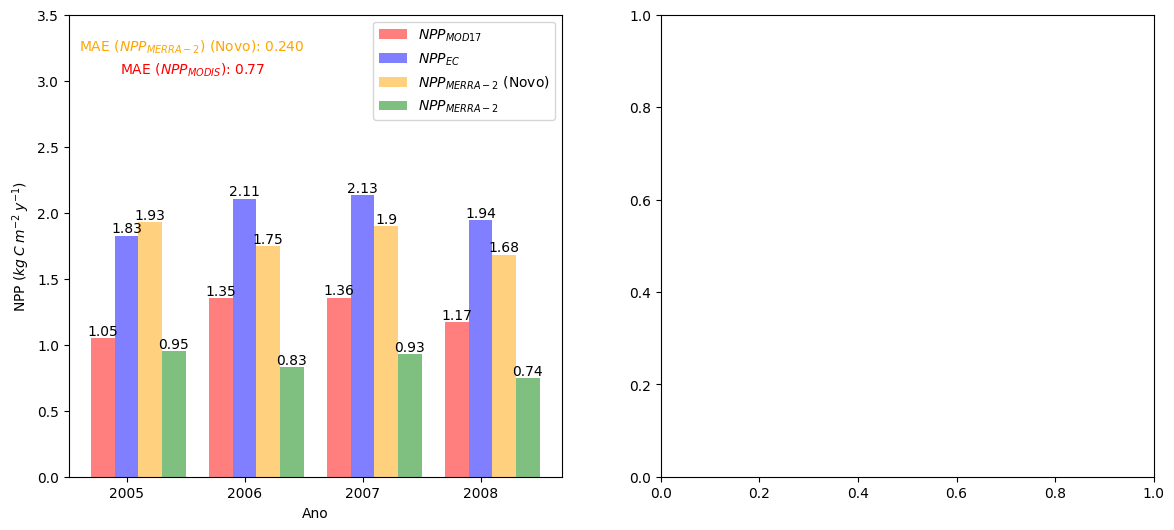

In [12]:
# Defina a largura das barras
largura_barra = 0.2

# Obter uma lista de anos únicos presentes nos dados
anos_unicos_caxiuana = observacoes_caxiuana.index.year.unique()

# Convertendo os anos em formato de string
anos_unicos_str_caxiuana = [str(ano) for ano in anos_unicos_caxiuana]

# Defina os deslocamentos das barras para os diferentes conjuntos de dados
deslocamento_caxiuana = np.arange(len(anos_unicos_caxiuana))

# Criação da figura e dos subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Convertendo os Series para arrays NumPy e, em seguida, utilizando o método reshape
npp_algoritmo_st_arr = np.array(npp_algoritmo_st)
npp_algoritmopad_st_arr = np.array(npp_algoritmopad_st)

# Plotando as barras agrupadas para cada conjunto de dados (caxiuana)
axs[0].bar(deslocamento_caxiuana - largura_barra, npp_modis_st.values, width=largura_barra, color='red', alpha=0.5, label='$NPP_{MOD17}$')
axs[0].bar(deslocamento_caxiuana, npp_caxiuana, width=largura_barra, color='blue', alpha=0.5, label='$NPP_{EC}$')
axs[0].bar(deslocamento_caxiuana + largura_barra, (npp_algoritmo_st_arr.flatten() / 1000), width=largura_barra, color='orange', alpha=0.5, label='$NPP_{MERRA-2}$ (Novo)')
axs[0].bar(deslocamento_caxiuana + 2*largura_barra, (npp_algoritmopad_st_arr.flatten() / 1000), width=largura_barra, color='green', alpha=0.5, label='$NPP_{MERRA-2}$')
axs[0].set_ylabel('NPP ($kg \: C \: m^{-2} \: y^{-1}$)')

mae_caxiuana = mean_absolute_error(npp_caxiuana, npp_algoritmo_st_arr / 1000)
mae_pad_caxiuana = mean_absolute_error(npp_caxiuana, npp_algoritmopad_st_arr.flatten() / 1000)
mae_modis_caxiuana = mean_absolute_error(npp_caxiuana, npp_modis_st.values)

axs[0].text(0.25, 0.9, 'MAE ($NPP_{MODIS}$):' + ' ' + f'{mae_modis_caxiuana:.2f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='red')
axs[0].text(0.25, 0.95, 'MAE ($NPP_{MERRA-2}$) (Novo):' + ' ' + f'{mae_caxiuana:.3f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='orange')

for i, valor in enumerate(npp_modis_st.values):
    axs[0].text(i - largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate(npp_caxiuana):
    axs[0].text(i, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmo_st_arr.flatten() / 1000)):
    axs[0].text(i + largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmopad_st_arr.flatten() / 1000)):
    axs[0].text(i + 2*largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')

# Adicionando legendas e rótulos (caxiuana)
axs[0].legend()
axs[0].set_ylim(top=3.5)
axs[0].set_xlabel('Ano')

axs[0].set_xticks(deslocamento_caxiuana)
axs[0].set_xticklabels(anos_unicos_str_caxiuana)

#plt.savefig('npp_otimizado.png')
plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\:'
<>:11: SyntaxWarning: invalid escape sequence '\:'
C:\Users\alanb\AppData\Local\Temp\ipykernel_13892\4121865817.py:11: SyntaxWarning: invalid escape sequence '\:'
  axs[0].set_ylabel('NPP ($kg \: C \: m^{-2} \: y^{-1}$)')


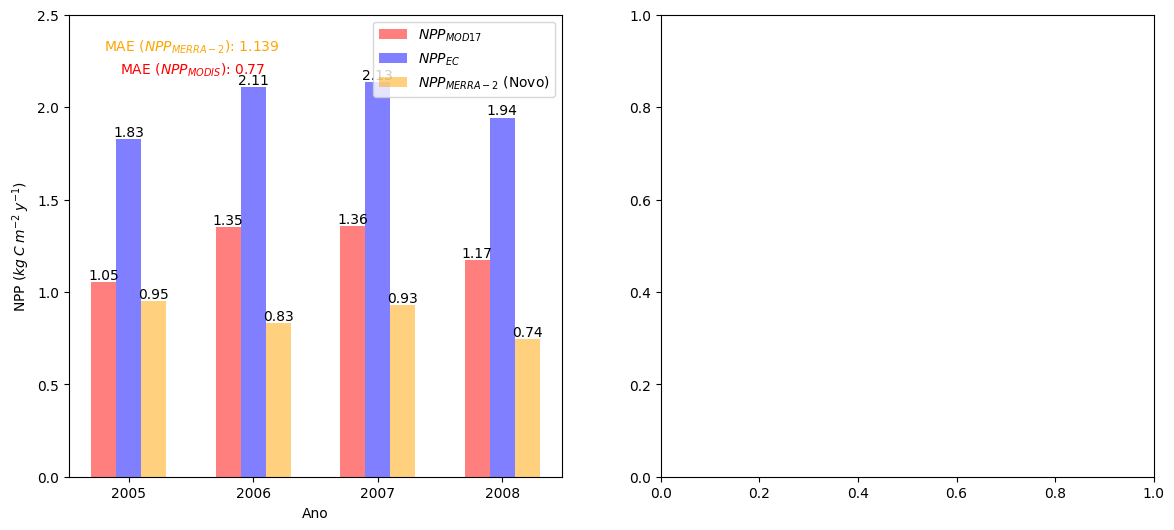

In [13]:
# Criação da figura e dos subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Convertendo os Series para arrays NumPy e, em seguida, utilizando o método reshape
npp_algoritmopad_st_arr = np.array(npp_algoritmopad_st)

# Plotando as barras agrupadas para cada conjunto de dados (caxiuana)
axs[0].bar(deslocamento_caxiuana - largura_barra, npp_modis_st.values, width=largura_barra, color='red', alpha=0.5, label='$NPP_{MOD17}$')
axs[0].bar(deslocamento_caxiuana, npp_caxiuana, width=largura_barra, color='blue', alpha=0.5, label='$NPP_{EC}$')
axs[0].bar(deslocamento_caxiuana + largura_barra, (npp_algoritmopad_st_arr.flatten() / 1000), width=largura_barra, color='orange', alpha=0.5, label='$NPP_{MERRA-2}$ (Novo)')
axs[0].set_ylabel('NPP ($kg \: C \: m^{-2} \: y^{-1}$)')

mae_modis_caxiuana = mean_absolute_error(npp_caxiuana, npp_modis_st.values)
mae_pad_caxiuana = mean_absolute_error(npp_caxiuana, npp_algoritmopad_st_arr / 1000)

axs[0].text(0.25, 0.9, 'MAE ($NPP_{MODIS}$):' + ' ' + f'{mae_modis_caxiuana:.2f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='red')
axs[0].text(0.25, 0.95, 'MAE ($NPP_{MERRA-2}$):' + ' ' + f'{mae_pad_caxiuana:.3f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='orange')

for i, valor in enumerate(npp_modis_st.values):
    axs[0].text(i - largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate(npp_caxiuana):
    axs[0].text(i, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmopad_st_arr.flatten() / 1000)):
    axs[0].text(i + largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')

# Adicionando legendas e rótulos (caxiuana)
axs[0].legend()
axs[0].set_ylim(top=2.5)
axs[0].set_xlabel('Ano')

axs[0].set_xticks(deslocamento_caxiuana)
axs[0].set_xticklabels(anos_unicos_str_caxiuana)

#plt.savefig('npp_original.png')
plt.show()